# Paremeter Set

In [ ]:
num_days = days # วันที่ต้องการทำนาย

# Predict TEMP model

In [7]:
import pycaret
import pandas as pd
import numpy as np

In [8]:
# อ่านไฟล์ CSV
data = pd.read_csv('../eng_psu_hatyai/export_data/filtered_data_3_best.csv')

In [9]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)


In [10]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data = pd.concat([data, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data = data.loc[~data.index.duplicated(keep='first')]


In [11]:
last_date_temp = data.index[-1].strftime('%Y-%m-%d')

In [12]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)


In [13]:
data.drop(columns=['pm_10', 'pm_2_5_sp', 'value'], inplace=True)

In [14]:
data_temp = data.copy()

data_temp.drop(columns=['humidity', 'pm_2_5'], inplace=True)

lag_size = 7
for i in range(1,lag_size+1):
    data_temp[f'temperature_lag_{i}'] = data_temp['temperature'].shift(i)

In [15]:
data_filtered = data_temp.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [16]:
from pycaret.regression import load_model, predict_model

model_temp = load_model("../eng_psu_hatyai/main/lgmb_temp_model_eng")


Transformation Pipeline and Model Successfully Loaded


In [17]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_temp

model = model_temp

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

## Plot Graph TEMP

In [18]:
#------------TEMP PREDICT VALUE--------------

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot_temp = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot_temp.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์

#---------------------------------------------


# Predict HUMI model

In [19]:
model_humi = load_model("../eng_psu_hatyai/main/humi_use_temp_model_2")

Transformation Pipeline and Model Successfully Loaded


In [20]:
# อ่านไฟล์ CSV
data_humi = data.copy()

data_humi.drop(columns=['pm_2_5'], inplace=True)

# ลบแถวล่าสุด (แถวสุดท้าย)
data_humi = data_humi.drop(data_humi.index[-1])

In [21]:
data_humi

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,month_sin,month_cos,day_of_week_sin,day_of_week_cos
2023-07-01 07:00:00,67.844074,31.131941,2023,7,1,5,26,1,1,2023-07-01,182,-0.500000,-0.866025,-0.974928,-0.222521
2023-07-02 07:00:00,68.552865,32.240924,2023,7,2,6,26,1,1,2023-07-02,183,-0.500000,-0.866025,-0.781831,0.623490
2023-07-03 07:00:00,63.142228,35.841610,2023,7,3,0,27,1,0,2023-07-03,184,-0.500000,-0.866025,0.000000,1.000000
2023-07-04 07:00:00,61.741030,36.269393,2023,7,4,1,27,1,0,2023-07-04,185,-0.500000,-0.866025,0.781831,0.623490
2023-07-05 07:00:00,62.085527,36.176134,2023,7,5,2,27,1,0,2023-07-05,186,-0.500000,-0.866025,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-07 07:00:00,NaN,NaN,2025,4,7,0,15,0,0,2025-04-07,97,0.866025,-0.500000,0.000000,1.000000
2025-04-08 07:00:00,NaN,NaN,2025,4,8,1,15,0,0,2025-04-08,98,0.866025,-0.500000,0.781831,0.623490
2025-04-09 07:00:00,NaN,NaN,2025,4,9,2,15,0,0,2025-04-09,99,0.866025,-0.500000,0.974928,-0.222521
2025-04-10 07:00:00,NaN,NaN,2025,4,10,3,15,0,0,2025-04-10,100,0.866025,-0.500000,0.433884,-0.900969


In [22]:
last_date_humi = data_humi.index[-1].strftime('%Y-%m-%d')

In [23]:
# add temp predict column
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

data_humi.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp


In [24]:
lag_size = 7
for i in range(1,lag_size+1):
    data_humi[f'humidity_lag_{i}'] = data_humi['humidity'].shift(i)

for i in range(1,lag_size+1):
    data_humi[f'temperature_lag_{i}'] = data_humi['temperature'].shift(i)
    

In [25]:
data_filtered = data_humi.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [26]:
data_compare = data_filtered.loc[:'2025-01-12']
result_humi = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_humi

model = model_humi

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['humidity'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'humidity'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_humi
    result_humi = pd.concat([result_humi, predict_test_1], axis=0)
    

## Plot Graph HUMI

In [27]:
#-----------PLOT GRAPH HUMI---------
real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot_humi = pd.concat([result_humi['prediction_label'].shift(-1), real_data['humidity']], axis=1)
result_plot_humi.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์
#------------------------------------

# Predict PM2.5

In [28]:
model_pm_2_5 = load_model("../eng_psu_hatyai/main/dt_model_eng")

Transformation Pipeline and Model Successfully Loaded


In [29]:
# อ่านไฟล์ CSV
data_pm_2_5 = data.copy()

# ลบ 2 แถวล่าสุด
data_pm_2_5 = data_pm_2_5.drop(data_pm_2_5.index[-2:])

In [30]:

last_date_pm_2_5 = data_pm_2_5.index[-1].strftime('%Y-%m-%d')


In [31]:

# add humi predict column

# เลื่อนค่าของ prediction_label ไปข้างหน้า 1 วัน และตัดค่าแถวสุดท้ายที่ไม่มีผล
shifted_predictions = result_humi['prediction_label'].shift(-1).iloc[:-1]

# สมมติว่า data_pm_2_5 และ shifted_predictions มีอยู่แล้ว
# data_pm_2_5 เป็น DataFrame ที่มีคอลัมน์ 'humidity' และ index เป็น timestamp
# shifted_predictions เป็น Series ที่มี index เป็น timestamp ในช่วงวันที่ 2025-01-13 ถึง 2025-02-10

# แทนที่ค่าของคอลัมน์ 'humidity' ใน data_pm_2_5 ด้วยค่าจาก shifted_predictions ในวันที่ตรงกัน
data_pm_2_5.loc[shifted_predictions.index, 'humidity'] = shifted_predictions


In [32]:

# เลื่อนค่าของ prediction_label ไปข้างหน้า 1 วัน และตัดค่าแถวสุดท้ายที่ไม่มีผล
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

# กรองข้อมูลที่มีวันที่น้อยกว่าหรือเท่ากับ last_day
shifted_predictions_temp = shifted_predictions_temp[:last_date_pm_2_5]

# แทนที่ค่าของคอลัมน์ 'temperature' ใน data_pm_2_5
data_pm_2_5.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp


In [33]:
data_pm_2_5['dew_point'] = data_pm_2_5['temperature'] - ((100 - data_pm_2_5['humidity']) / 5)
# อัตราส่วนของอุณหภูมิต่อความชื้น
data_pm_2_5["temp_humidity_ratio"] = data_pm_2_5["temperature"] / (data_pm_2_5["humidity"] + 1)
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data_pm_2_5["temperature"]
RH = data_pm_2_5["humidity"]

data_pm_2_5["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

# ความชื้นสัมพัทธ์เชิงดัชนี
data_pm_2_5["rh_index"] = data_pm_2_5["humidity"] ** 2 / (data_pm_2_5["temperature"] + 1)


In [34]:
# เพิ่มฟีเจอร์ day_of_year
data_pm_2_5['date'] = pd.to_datetime(data_pm_2_5[['year', 'month', 'day']])
data_pm_2_5['day_of_year'] = data_pm_2_5['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data_pm_2_5['month_sin'] = np.sin(2 * np.pi * data_pm_2_5['month'] / 12)
data_pm_2_5['month_cos'] = np.cos(2 * np.pi * data_pm_2_5['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data_pm_2_5['day_of_week_sin'] = np.sin(2 * np.pi * data_pm_2_5['day_of_week'] / 7)
data_pm_2_5['day_of_week_cos'] = np.cos(2 * np.pi * data_pm_2_5['day_of_week'] / 7)

lag_size = 30
for i in range(1,lag_size+1):
    data_pm_2_5[f'pm_2_5_lag_{i}'] = data_pm_2_5['pm_2_5'].shift(i)

data_pm_2_5['humidity_lag_1'] = data_pm_2_5['humidity'].shift(1)
data_pm_2_5['humidity_lag_2'] = data_pm_2_5['humidity'].shift(2)
data_pm_2_5['humidity_lag_3'] = data_pm_2_5['humidity'].shift(3)
data_pm_2_5['humidity_lag_7'] = data_pm_2_5['humidity'].shift(7)

data_pm_2_5['temperature_lag_1'] = data_pm_2_5['temperature'].shift(1)
data_pm_2_5['temperature_lag_2'] = data_pm_2_5['temperature'].shift(2)
data_pm_2_5['temperature_lag_3'] = data_pm_2_5['temperature'].shift(3)
data_pm_2_5['temperature_lag_7'] = data_pm_2_5['temperature'].shift(7)


In [35]:
data_filtered = data_pm_2_5.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป


In [36]:
data_compare = data_filtered.loc[:'2025-01-12']
result_pm_2_5 = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_pm_2_5

model = model_pm_2_5

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_pm_2_5
    result_pm_2_5 = pd.concat([result_pm_2_5, predict_test_1], axis=0)


## Plot Graph PM2.5

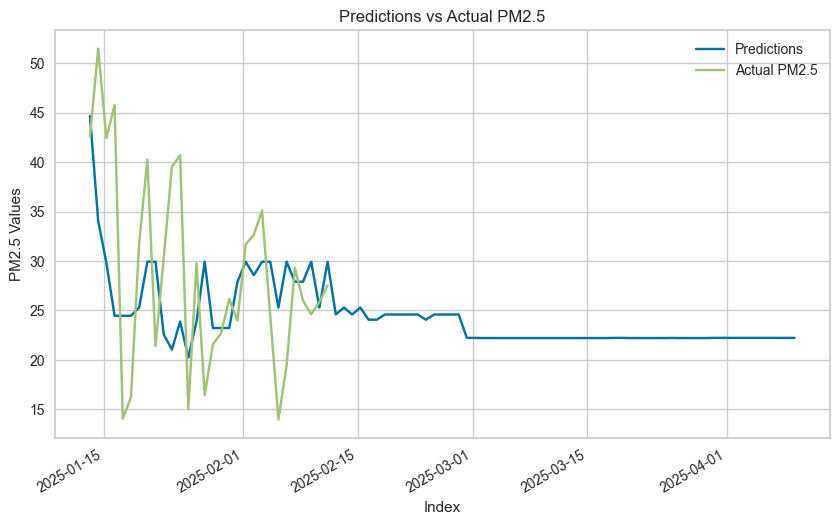

In [37]:
# คำนวณวัน
from datetime import datetime, timedelta

# แปลง str เป็น datetime
date_str = "2025-01-13"
date_obj = datetime.strptime(date_str, "%Y-%m-%d")

# บวกวัน
days_to_add = days - 1  # จำนวนวันที่ต้องการบวก
new_date = date_obj + timedelta(days=days_to_add)

# แสดงผลลัพธ์
print(new_date.strftime("%Y-%m-%d"))

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot_pm_2_5 = pd.concat(
    [
        (result_pm_2_5["prediction_label"].shift(-1))[start_date:new_date],
        real_data["pm_2_5"],
    ],
    axis=1,
)
result_plot_pm_2_5.columns = ["Predictions", "Actual PM2.5"]